In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("lea_absenteeism_x_graduation_2017_18.csv")

df = df[df["total_enrollment"] >= 100]

X = sm.add_constant(df["weighted_absent_rate"])
y = df["grad_rate"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              grad_rate   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     91.95
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           1.68e-21
Time:                        21:22:28   Log-Likelihood:                -13242.
No. Observations:                3341   AIC:                         2.649e+04
Df Residuals:                    3339   BIC:                         2.650e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   85.1611 

In [2]:
# Compute predictions and residuals
df["predicted_grad_rate"] = model.predict(X)
df["residual"] = df["grad_rate"] - df["predicted_grad_rate"]

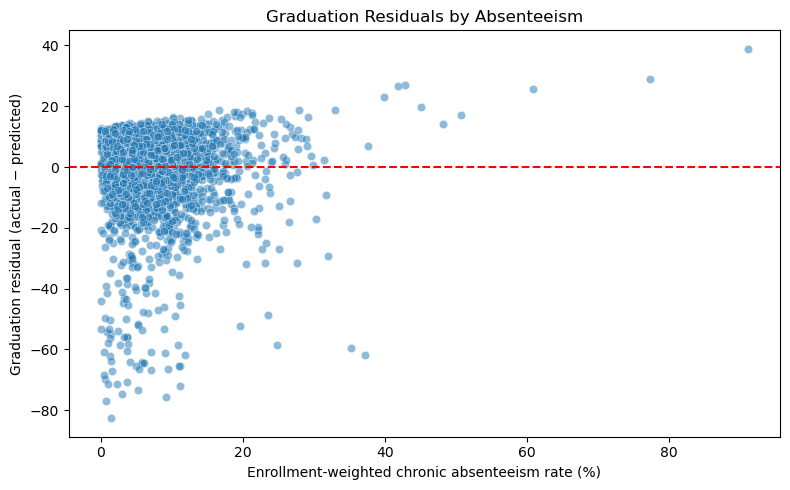

In [3]:
# Visual check: residuals vs absenteeism
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="weighted_absent_rate",
    y="residual",
    alpha=0.5
)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Enrollment-weighted chronic absenteeism rate (%)")
plt.ylabel("Graduation residual (actual − predicted)")
plt.title("Graduation Residuals by Absenteeism")
plt.tight_layout()
plt.show()

In [4]:
# Top overperformers
overperformers = (
    df.sort_values("residual", ascending=False)
      .head(10)
      [["LEAID", "weighted_absent_rate", "grad_rate", "predicted_grad_rate", "residual", "total_enrollment"]]
)

# Top underperformers
underperformers = (
    df.sort_values("residual", ascending=True)
      .head(10)
      [["LEAID", "weighted_absent_rate", "grad_rate", "predicted_grad_rate", "residual", "total_enrollment"]]
)

overperformers, underperformers

(        LEAID  weighted_absent_rate  grad_rate  predicted_grad_rate  \
 2799  4808550             91.098485  89.750000            50.846999   
 2807  4809670             77.331731  84.961538            56.032532   
 2896  4823820             42.784810  96.166667            69.045345   
 2924  4827690             41.864717  96.000000            69.391918   
 2990  4839990             60.804020  87.823529            62.258037   
 2824  4812480             39.830508  93.250000            70.158144   
 3016  4844160             45.077720  87.937500            68.181673   
 2804  4809450             16.666667  97.750000            78.883285   
 2829  4813530             27.872340  93.500000            74.662436   
 347    627690             32.919255  91.500000            72.761411   
 
        residual  total_enrollment  
 2799  38.903001             528.0  
 2807  28.929006            4160.0  
 2896  27.121321             395.0  
 2924  26.608082             547.0  
 2990  25.565493     

In [5]:
# Filtering for size
priority_underperformers = df[
    (df["residual"] < -5) & (df["total_enrollment"] >= 500)
].sort_values("residual")

priority_underperformers.head(10)

,LEAID,total_enrollment,num_schools_reporting,mean_school_absent_rate,weighted_absent_rate,grad_rate,predicted_grad_rate,residual
619,1300246,962.0,1,0.727651,0.727651,8.000000,84.887046,-76.887046
617,1300235,1802.0,1,2.941176,2.941176,9.500000,84.053276,-74.553276
445,691007,1315.0,4,7.926613,5.247148,10.000000,83.184684,-73.184684
876,1800159,525.0,1,2.285714,2.285714,13.000000,84.300169,-71.300169
869,1800093,1547.0,1,0.517130,0.517130,15.285714,84.966343,-69.680629
873,1800135,563.0,1,0.355240,0.355240,16.500000,85.027322,-68.527322
615,1300214,2472.0,1,1.577670,1.577670,17.333333,84.566869,-67.233535
1451,2700025,2064.0,15,17.099190,7.025194,15.909091,82.514946,-66.605855
169,600015,1074.0,5,13.653304,9.497207,15.000000,81.583811,-66.583811
2233,3900118,1887.0,1,5.299417,5.299417,16.625000,83.164995,-66.539995


## Residual Analysis: Interpreting Over- and Under-Performance

The residual plot shows substantial dispersion around the fitted relationship between chronic absenteeism and graduation rates, reinforcing that absenteeism alone does not determine outcomes. However, the **tails of the distribution are highly informative** for prioritization.

### Over-performing districts (positive residuals)

A small set of districts graduate students at **20–40 percentage points above** what would be expected given their absenteeism levels. Notably, several of these districts exhibit **very high absenteeism rates (40–90%)** yet still achieve graduation rates near or above 90%.

For example:
- Some districts with **absenteeism above 75%** graduate nearly **90% of students**, outperforming model expectations by **~30–40 points**.
- These districts often have **moderate to large enrollments**, suggesting performance is not driven solely by small-cohort noise.

These cases likely reflect **mitigating factors beyond attendance**—such as alternative pathways, credit recovery, or targeted supports—and represent potential **learning opportunities** rather than immediate intervention targets.

### Under-performing districts (negative residuals)

Conversely, the most concerning pattern appears among districts with **very low absenteeism (often under 5%)** but **extremely low graduation rates**, in some cases below 15%.

Key observations:
- Several districts with absenteeism near **1–3%** graduate **fewer than 10% of students**, missing expectations by **60–80 points**.
- Many of these districts serve **hundreds to thousands of students**, indicating the pattern is not driven solely by data sparsity.
- These districts cluster tightly near the left side of the plot but far below the zero-residual line, making them visually distinct priority cases.

This pattern suggests that **attendance alone is insufficient** to explain graduation failure in these contexts, and that **structural or programmatic issues** may be overwhelming the protective effect of high attendance.

### Implications for prioritization

Residuals provide a practical way to move from correlation to action:
- **Large negative residuals** identify districts where graduation outcomes lag expectations even after accounting for attendance, making them **high-priority intervention targets**.
- **Large positive residuals** highlight districts that appear to buffer attendance risk effectively and may warrant **qualitative follow-up** or peer learning.

Overall, this analysis supports framing chronic absenteeism as an **early risk signal**, while emphasizing that **interventions must be context-sensitive** and informed by factors beyond attendance alone.
